<img src="https://raw.githubusercontent.com/jdeldre/MAE150A/master/notebook/logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **MAE 150A - Intermediate Fluid Mechanics**
<hr />

# Computational solution of Navier-Stokes equations

In this notebook, we present "numerical" solution of the Navier-Stokes equations---
that is, we solve the equations on the computer instead of by hand. We won't
discuss the details of how we do this. However, the basic idea is as follows.

- **We replace the space in which we are solving the problem by a grid (or 'mesh') of points.**
Imagine taking your graph paper and assigning a unique pair of integers to each cell on the page,
e.g, cell $(10,5)$ would be 10 cells over and 5 cells up. The side length of each cell is called the grid spacing or cell size,
$\Delta x$. (In three dimensions it would be similar, but there would be a third index.)

- Every cell would have a set of unknowns (e.g., $u$ velocity, $v$ velocity, and pressure). So, for example, in place of
writing $u(x,y)$ for the $u$ velocity at point $x,y$, we write $u_{ij}$ for the value of
$u$ at cell $ij$.) The full set of unknowns on the grid can be written as a vector, i.e.,
we arrange all of these unknown values as a long ordered list. We call this vector
the **solution vector** `u`. (Note that `u` contains the unknown $u$, $v$ and $p$ values.)
So, if there are $N_x$ and $N_y$ cells in the respective directions, then there are $N_xN_y$ cells.
Since there are three unknowns for each cell $(u,v,p)$, there are $3N_xN_y$ total unknowns in `u`.

- We replace each spatial derivative like $\partial u/\partial x$ or $\partial u/\partial y$
 with a "finite difference" approximation, e.g.,

 $$ \left.\dfrac{\partial u}{\partial x} \right|_{ij} \approx \dfrac{u_{i+1,j}-u_{i,j}}{\Delta x}$$

and

 $$ \left.\dfrac{\partial^2 u}{\partial x^2} \right|_{ij} \approx \dfrac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{\Delta x}$$

- After doing this, the original partial differential equations (in space and time) become a large
set of ordinary differential equations (in time) for the solution vector `u`,
(an ODE for each cell's unknowns). There are $3N_xN_y$ equations ($N_xN_y$
Navier-Stokes equations for the $u$ velocity, $N_xN_y$
Navier-Stokes equations for the $v$ velocity, $N_xN_y$ continuity equations). This set
of ODEs can be solved by a time marching scheme.

- A small detail: the approach we use is actually focused on solving for vorticity
and streamfunction (2 unknowns) rather than velocity and pressure (3 unknowns).
(Can you think of a reason why this might be helpful, other than having fewer unknowns?)

For further details, you will have to consult other references, or take 182C and/or 150B.
In the code below, you won't see these details shown, but they are all done behind the scenes.

### Set up the module

In [1]:
using MAE150A

In [2]:
using ViscousFlow
using Plots

### Objective
We will solve for the two-dimensional flow past a stationary body. Let's suppose
that the free stream velocity is $U_\infty$, the kinematic viscosity is $\nu$,
and the characteristic length of the body is $L$. Then, the Reynolds number
is $Re = U_\infty L/\nu$. Here, we will simulate a flow at Reynolds number in
the laminar regime (less than $\sim 1000$), because we don't want to have to worry about RANS and
turbulence modeling.

Rather than set $U_\infty$, $L$ and $\nu$ separately, we will set Reynolds number
directly. Basically, this means that we have already non-dimensionalized the
problem, so we set nondimensional free stream velocity in $x$ direction to 1
and the nondimensional length of the body to 1, and there is no need to change
these values.

In [3]:
Re = 200 # Reynolds number
U = 1.0 #
U∞ = (U,0.0);

### Discretize
We need to set up our grid of cells. This grid needs to be large enough to
include the region around the body and some part of the wake. (We set the
parameter `gridRe` to 4.0 here to get a quicker solution, though it is generally
better to make this smaller (it defaults to 2.0 if you don't set it).

In [4]:
xlim = (-1.0,3.0)
ylim = (-1.5,1.5)
Δx, Δt = setstepsizes(Re,gridRe=4.0)

(0.02, 0.01)

### Set up bodies
Here, we will set up a rectangle of half-height 0.5 (so its height is 1) and half-width 0.25
at 45 degrees angle of attack. The function below sets up the basic body shape.

In [5]:
body = Rectangle(0.5,0.25,1.5Δx)

Rectangular body with 96 points and half-lengths (0.5,0.25)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


We place the body at a desired location and orientation with the `RigidTransform`
function. This function creates an operator `T` that acts in-place on the body:
after the operation is applied, `body` is transformed to the correct location/orientation.

In [6]:
cent = (0.0,0.0) # center of body
α = 45π/180 # angle
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

Rectangular body with 96 points and half-lengths (0.5,0.25)
   Current position: (0.0,0.0)
   Current angle (rad): 0.7853981633974483


Let's plot it just to make sure

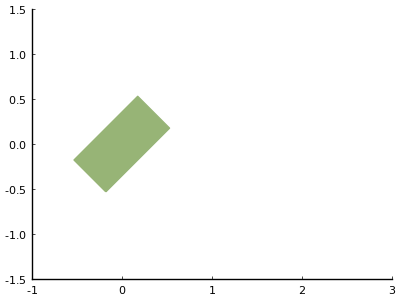

In [7]:
plot(body,xlim=xlim,ylim=ylim)

### Construct the system structure
This step is like the previous notebook, but now we also provide the body and
the freestream:

In [8]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt,body,freestream = U∞)

External flow Navier-Stokes system on a grid of size 208 x 154 and 96 static immersed points
   Static freestream = (1.0, 0.0)
   1 body


### Initialize
Now, we initialize with zero vorticity. Note that we do this by calling
`newstate` with no argument except for `sys` itself.

In [9]:
u0 = newstate(sys)

(Dual nodes in a (nx = 208, ny = 154) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 154), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

and now create the integrator, with a long enough time span to hold the whole
solution history:

In [10]:
tspan = (0.0,20.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 208, ny = 154) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 154), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

### Solve
Now we are ready to solve the problem. Let's advance the solution to $t = 10$.

In [11]:
@time step!(integrator,10.0)

124.683898 seconds (1.18 G allocations: 45.267 GiB, 5.60% gc time)


### Examine
Let's look at the flow field at the end of this interval

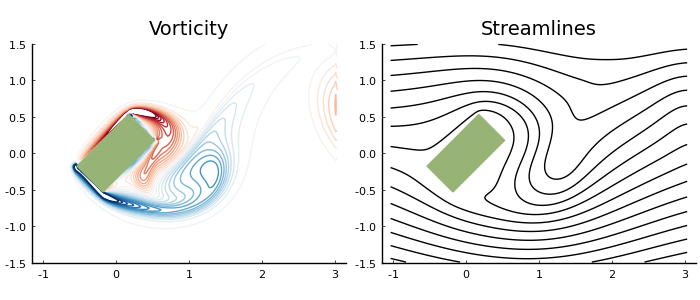

In [12]:
plot(
plot(vorticity(integrator),sys,title="Vorticity",clim=(-10,10),levels=range(-10,10,length=30), color = :RdBu,ylim=ylim),
plot(streamfunction(integrator),sys,title="Streamlines",ylim=ylim,color = :Black),
    size=(700,300)
    )

Now let's make a movie, like we did last time.

┌ Info: Saved animation to 
│   fn = /Users/jeff/JuliaProjects/MAE150A/notebook/tmp.gif
└ @ Plots /Users/jeff/.julia/packages/Plots/lmp2A/src/animation.jl:104


Plots.AnimatedGif("/Users/jeff/JuliaProjects/MAE150A/notebook/tmp.gif")
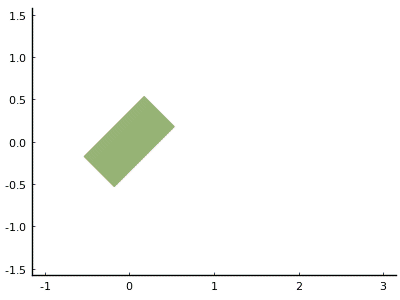

In [13]:
sol = integrator.sol;
@gif for (u,t) in zip(sol.u,sol.t)
    plot(vorticity(u,sys,t),sys,clim=(-10,10),levels=range(-10,10,length=30), color = :RdBu)
end every 5

#### Compute the force history
To do this, we supply the solution history `sol`, the system `sys`, and the index
of the body (1).

In [14]:
fx, fy = force(sol,sys,1);

Plot the histories. Note that we are actually plotting the drag and lift
coefficient histories here:
$$ C_D = \dfrac{F_x}{\frac{1}{2}\rho U_\infty^2 L}, \quad C_L = \dfrac{F_y}{\frac{1}{2}\rho U_\infty^2 L} $$
Since the quantities in this simulation are already scaled by $\rho$, $U_\infty$, and $L$
(because $\rho$ has been scaled out of the equations, and the free stream speed is
set to 1 and the height of the shape to 1), then we obtain these coefficients by
simply dividing by 1/2, or equivalently, by multiplying by 2:

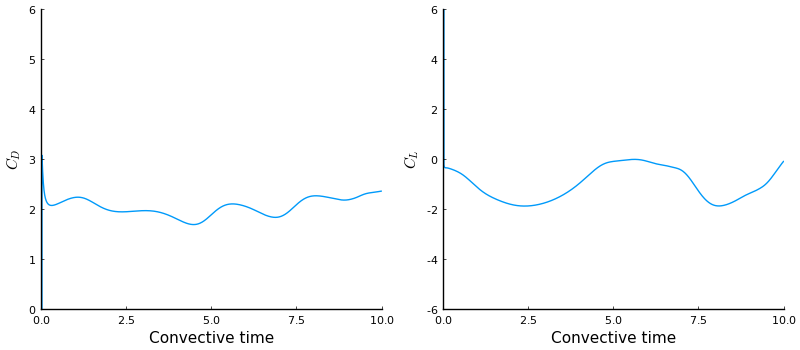

In [15]:
plot(
plot(sol.t,2*fx,xlim=(0,Inf),ylim=(0,6),xlabel="Convective time",ylabel="\$C_D\$",legend=:false),
plot(sol.t,2*fy,xlim=(0,Inf),ylim=(-6,6),xlabel="Convective time",ylabel="\$C_L\$",legend=:false),
    size=(800,350)
)

The mean drag and lift coefficients are

In [16]:
meanCD = GridUtilities.mean(2*fx)

1.797876452724847

In [17]:
meanCL = GridUtilities.mean(2*fy)

-0.9291942254146506

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*